In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime

Geopandas is just a GIS-enabled variant of the popular data science library Pandas.

In [2]:
file = "/home/delta/devel/spotthedifference/michael/data/connor_2020-02-10T13_39_00-07_00.geojson"
df = gpd.read_file(file)

In [3]:
df.head(2)

,algorithm,background_maximum_return,background_mean_return,background_minimum_return,centroid_lat,centroid_lon,change_area,compactness,detect_strength,detect_type,...,shape_extent_minor,shape_orientation,target_maximum_return,target_mean_return,target_minimum_return,target_total_return,timestamp,weighted_centroid_lat,weighted_centroid_lon,geometry
0,ACD-29August2019,7.82,3.15,0.02,33.066993,41.831021,329.63,1.0846,-26.4,Departure,...,18.09,56.5993,1873.72,905.93,101.19,6341.48,2018-11-06T00:00:00,33.067041,41.831040,POINT Z (41.83098 33.06712 0.00000)
1,ACD-29August2019,23.01,8.48,1.59,33.065138,41.833288,423.81,1.0200,-25.4,Departure,...,19.94,58.2825,2993.64,980.92,49.94,8828.28,2018-11-06T00:00:00,33.065097,41.833273,POINT Z (41.83325 33.06526 0.00000)


In [4]:
print(df.columns)

Index(['algorithm', 'background_maximum_return', 'background_mean_return',
       'background_minimum_return', 'centroid_lat', 'centroid_lon',
       'change_area', 'compactness', 'detect_strength', 'detect_type',
       'eccentricity', 'iids', 'name', 'perimeter', 'pixel_count',
       'processing_type', 'ref_azimuth_angle', 'ref_graze_angle',
       'return_units', 'sec_azimuth_angle', 'sec_graze_angle',
       'shape_extent_major', 'shape_extent_minor', 'shape_orientation',
       'target_maximum_return', 'target_mean_return', 'target_minimum_return',
       'target_total_return', 'timestamp', 'weighted_centroid_lat',
       'weighted_centroid_lon', 'geometry'],
      dtype='object')


In [5]:
# Timestamps are usually read as strings by default
# here we create a new column with the timestamps read as proper datetime objects for future processing
df["timestamp_dt"] = df["timestamp"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S"))

In [6]:
# sanity check
df["timestamp_dt"].head(10)

0   2018-11-06
1   2018-11-06
2   2018-11-12
3   2018-11-12
4   2018-11-17
5   2018-11-17
6   2018-11-17
7   2018-11-29
8   2018-11-30
9   2018-12-05
Name: timestamp_dt, dtype: datetime64[ns]

In [7]:
df.loc[df["detect_type"] == "Departure"].head(2)

,algorithm,background_maximum_return,background_mean_return,background_minimum_return,centroid_lat,centroid_lon,change_area,compactness,detect_strength,detect_type,...,shape_orientation,target_maximum_return,target_mean_return,target_minimum_return,target_total_return,timestamp,weighted_centroid_lat,weighted_centroid_lon,geometry,timestamp_dt
0,ACD-29August2019,7.82,3.15,0.02,33.066993,41.831021,329.63,1.0846,-26.4,Departure,...,56.5993,1873.72,905.93,101.19,6341.48,2018-11-06T00:00:00,33.067041,41.831040,POINT Z (41.83098 33.06712 0.00000),2018-11-06
1,ACD-29August2019,23.01,8.48,1.59,33.065138,41.833288,423.81,1.0200,-25.4,Departure,...,58.2825,2993.64,980.92,49.94,8828.28,2018-11-06T00:00:00,33.065097,41.833273,POINT Z (41.83325 33.06526 0.00000),2018-11-06


In [8]:
# build dataframes of arrivals and departures separately
df_departures = df.loc[df["detect_type"] == "Departure"].copy()
df_arrivals = df.loc[df["detect_type"] == "Arrival"].copy()

# create columns of year of timestamp and month of timestamp for code readability (could be done in the groupby)
df_departures["timestamp_year"] = df_departures["timestamp_dt"].apply(lambda x: x.year)
df_departures["timestamp_month"] = df_departures["timestamp_dt"].apply(lambda x: x.month)

# group the data by unique month of timestamp
departures_by_month = df_departures.groupby([
    df_departures["timestamp_year"],
    df_departures["timestamp_month"]
])

# here the inline year/month is demonstrated, same functionality as above
arrivals_by_month = df_arrivals.groupby([
    df_arrivals["timestamp_dt"].apply(lambda x: x.year),
    df_arrivals["timestamp_dt"].apply(lambda x: x.month)])

The following graph is the total number of departure and arrival points by month.

Text(0, 0.5, 'Number of departures')

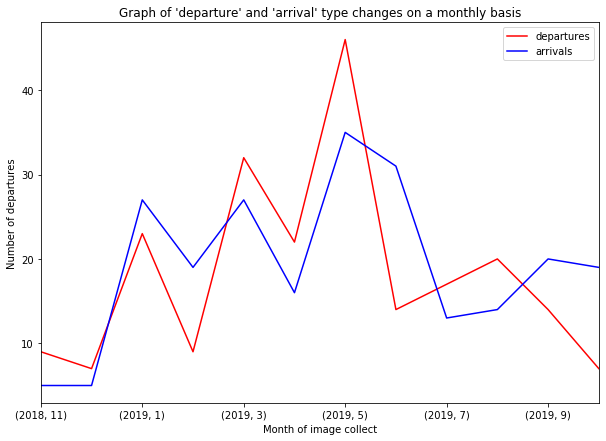

In [9]:
fig, ax = plt.subplots(figsize=(10,7))

departures_per_month = departures_by_month["detect_type"].count()
arrivals_per_month = arrivals_by_month["detect_type"].count()
departures_per_month.plot(label="departures", ax=ax, color="red")
arrivals_per_month.plot(label="arrivals", ax=ax, color="blue")
ax.legend()
ax.set_title("Graph of 'departure' and 'arrival' type changes on a monthly basis")#, color="white")
ax.set_xlabel("Month of image collect")#, color="white")
ax.set_ylabel("Number of departures")#, color="white")

# ax.xaxis.label.set_color("white")
# ax.yaxis.label.set_color("white")
#ax.tick_params(axis="x", colors="white")
#ax.tick_params(axis="y", colors="white")

The following graph is the difference between departures and arrivals by month.

Text(0, 0.5, 'Departures - arrivals')

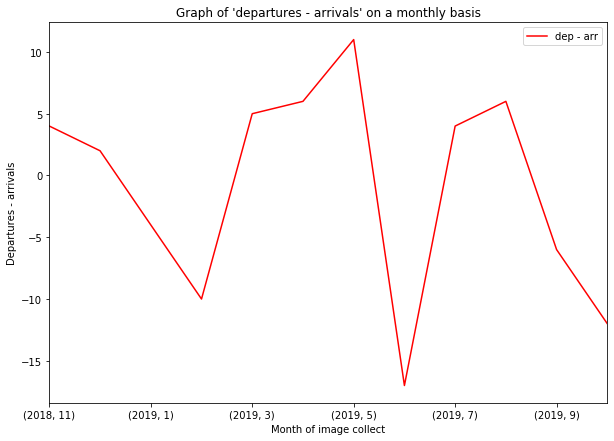

In [10]:
fig, ax = plt.subplots(figsize=(10,7))
dep_min_arr_per_month = departures_per_month - arrivals_per_month
dep_min_arr_per_month.plot(label="dep - arr", ax=ax, color="red")
ax.legend()
ax.set_title("Graph of 'departures - arrivals' on a monthly basis")#, color="white")
ax.set_xlabel("Month of image collect")#, color="white")
ax.set_ylabel("Departures - arrivals")#, color="white")

# ax.xaxis.label.set_color("white")
# ax.yaxis.label.set_color("white")
#ax.tick_params(axis="x", colors="white")
#ax.tick_params(axis="y", colors="white")

The following graph is of the max and 75th percentile of "target mean return" for arrivals and departures on a montly basis.

In [11]:
max_tmr_departures_per_month = departures_by_month["target_mean_return"].max()
max_tmr_arrivals_per_month = arrivals_by_month["target_mean_return"].max()
p75_tmr_departures_per_month = departures_by_month["target_mean_return"].quantile(.75)
p75_tmr_arrivals_per_month = arrivals_by_month["target_mean_return"].quantile(.75)

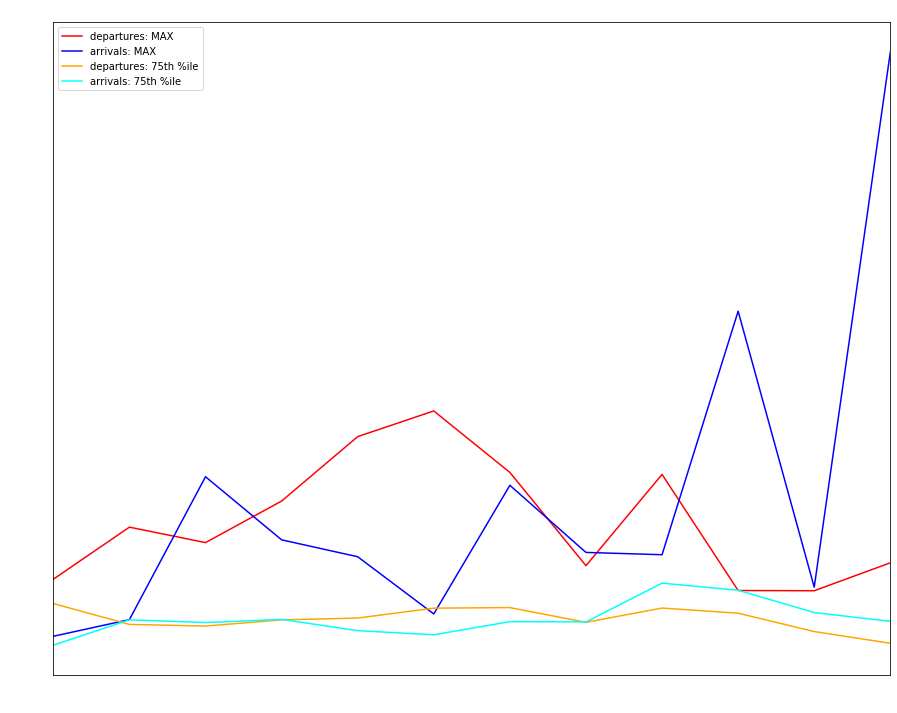

In [12]:
fig, ax = plt.subplots(figsize=(15,12))
max_tmr_departures_per_month.plot(label="departures: MAX", ax=ax, color="red")
max_tmr_arrivals_per_month.plot(label="arrivals: MAX", ax=ax, color="blue")
p75_tmr_departures_per_month.plot(label="departures: 75th %ile", ax=ax, color="orange")
p75_tmr_arrivals_per_month.plot(label="arrivals: 75th %ile", ax=ax, color="cyan")
ax.set_title("Graph of Target Mean Return per month", color="white")
ax.set_xlabel("Month", color="white")
ax.set_ylabel("Target Mean Return", color="white")
ax.legend()
ax.tick_params(axis="x", colors="white")
ax.tick_params(axis="y", colors="white")

The following was an attempt to visualize total departure points on a per-timestamp basis. I believe we run into issues here because this isn't a good way of viewing the data and the region we are investigating in this data is probably covered by two different swathes, creating an odd (and probably imbalanced) cadence of timestamps for points.

Text(0, 0.5, 'Number of departures')

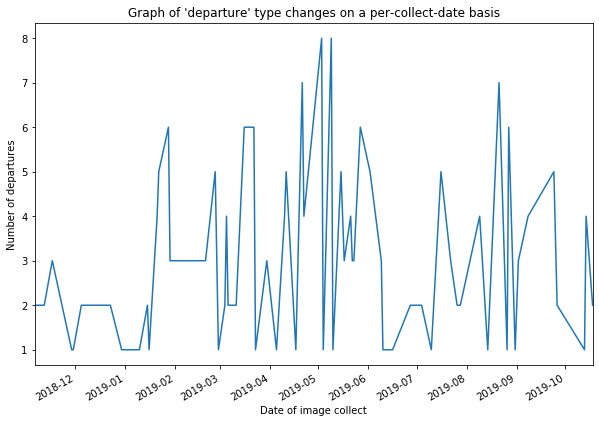

In [13]:
departures_by_date = df_departures.groupby(df_departures["timestamp_dt"])["detect_type"].count()

ax = departures_by_date.plot(figsize=(10,7))
ax.set_title("Graph of 'departure' type changes on a per-collect-date basis")
ax.set_xlabel("Date of image collect")
ax.set_ylabel("Number of departures")